In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.feature_extraction.text import CountVectorizer

import re
from datetime import timedelta as td
from dateutil.relativedelta import relativedelta
from datetime import datetime as dt
import gzip
import time
import uuid
import matplotlib.pyplot as plt


In [8]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.

    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) ->
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
in_path = './../../' 
t = pd.read_csv(in_path+'splunk_data_180918_telenor.txt',  encoding="ISO-8859-1", dtype={"user_id": int, "visit_id": int, "sequence": int, "start_time":object, "event_duration":float,"url":str, "action":str, "country":str,"user_client":str,"user_client_family":str,"user_experience":str,"user_os":str,"apdex_user_experience":str,"bounce_rate":float,"session_duration":float})
t.columns = t.columns.str.replace('min_bedrift_event.','')

In [9]:

# ToDelete: just pick 20000
t = t.tail(20000)

In [10]:

# downcast 64 to 32 to save memory
floats_to_convert = t.columns[t.dtypes == 'float64'].tolist()
for i in floats_to_convert:
    t[i] = np.array(t[i], dtype=np.float32)
ints_to_convert = t.columns[t.dtypes == 'int64'].tolist()
for i in ints_to_convert:
    t[i] = np.array(t[i], dtype=np.int32)


In [11]:

# define time variables
t['start_time'] = t['start_time'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d %H:%M:%S:%f"))
t['start_time'] = t['start_time'].apply(lambda x: x.replace(microsecond=0))

t['date'] = t['start_time'].dt.date
t['hour'] = t['start_time'].dt.hour
t['DOW'] = t['start_time'].dt.dayofweek


In [12]:

# create new session_id based on load = "new browser session"
# visit_id is not a good measure, since people remain logged in for 1 hour. This was previously 2 hours.
# in the App, people remain logged in for 11 months, so visit_ids could carry on for a long time
# Advice: I would define a session based on inactivity. Create new session after 30 minutes inactivity
t.sort_values(['visit_id', 'start_time'], inplace=True)
cond = t.action == '_load_'
t['tmp'] = cond.groupby(t.visit_id).cumsum().where(cond, 0).astype(int).replace(to_replace=0, method='ffill')

t['sequence'] = t.groupby(['tmp', 'visit_id']).cumcount() + 1
t['UUID'] = 1
t.loc[:, "UUID"] = t.groupby(['user', 'tmp', 'visit_id'])['UUID'].transform(lambda g: uuid.uuid4())


In [13]:
# drop all sessions with 1 event (since they are duplicates)
t['uuid_count'] = t.groupby('UUID').UUID.transform('count')
t = t[t.uuid_count > 1]

In [14]:

# hardcode event_duration = zero when sequence ==1
# event_duration may not be totally reliable
t['event_duration'] = np.where(t.sequence==1, 0, t['event_duration'])


In [15]:

# Exploratory data analysis
mean_sessions = t.groupby('user')['UUID'].nunique().mean()
print("On average every user has {} sessions.".format(mean_sessions))


On average every user has 1.658312447786132 sessions.


In [16]:

# which user logs in most
t['nvisits'] = t.groupby('user')['UUID'].transform(lambda x:x.nunique())
max_visits = t.groupby('user').UUID.nunique().max()
c = t.groupby('user').UUID.nunique().reset_index()
c.head()
t[t.nvisits==max_visits].user.head()

3853309    10859
3853310    10859
3853311    10859
3853313    10859
3853314    10859
Name: user, dtype: int32

Text(0.5,1,'Popular users')

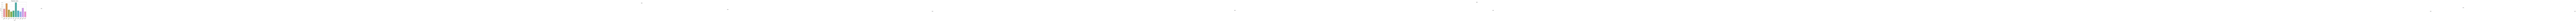

In [17]:

#### couple of graphs
# top users
df = t.groupby("user")["UUID"].nunique().reset_index()
df['percent'] = (df['UUID']/df['UUID'].sum())*100
df = df.sort_values("percent", ascending=False)
# top users
sns.set(style="whitegrid")
ax = sns.barplot(x="user", y="percent", data=df.head(10))
ax.set_xticklabels(df["user"], rotation=40)
for index, row in df.head(10).iterrows():
    ax.text(row.name,row.percent, round(row.percent,1), color='black', ha="center")
plt.title("Popular users", fontsize=15)

Text(0.5,1,'Popular user clients')

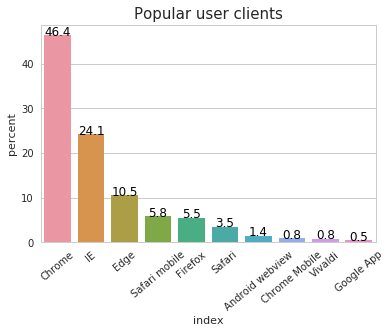

In [18]:

# popular user clients
df = t.user_client_family.value_counts().reset_index()
df['percent'] = (df['user_client_family']/df['user_client_family'].sum())*100

sns.set(style="whitegrid")
ax = sns.barplot(x="index", y="percent", data=df.head(10))
ax.set_xticklabels(df["index"], rotation=40)
for index, row in df.head(10).iterrows():
    ax.text(row.name,row.percent, round(row.percent,1), color='black', ha="center")
plt.title("Popular user clients", fontsize=15)

In [19]:

# how many clients do people use
t.groupby('user')['user_client_family'].nunique().mean()


0.8270676691729323

In [20]:

# globalsearch - What do people search for?
search = t[(t.url.notnull()) & (t.url.str.contains('globalsearch'))]
# search.loc[~search['url'].isnull(), 'keyword'] = search.url.str.split("=")[1]
search['keywords'] = search.url.transform(lambda x: re.findall('\=(.*)',str(x))[0])
search = search[~search.keywords.isin(["tab","C3","c3","b8","a5"])]
tmp = pd.DataFrame(get_top_n_words(search.keywords, 20), columns=['keyword','counts'])
tmp = tmp[~tmp.keyword.isin(["tab","C3","c3","b8","a5"])]

/home/aksel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Text(0,0.5,'percent')

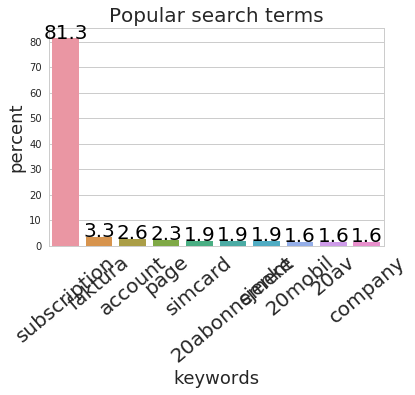

In [21]:

# plot
tmp_plt = tmp.head(10).reset_index()
tmp_plt['percent'] = (tmp_plt.counts/tmp_plt.counts.sum())*100
tmp_plt = tmp_plt.drop('counts',axis=1)
ax = sns.barplot(x="keyword", y="percent", data=tmp_plt)
ax.set_xticklabels(tmp_plt["keyword"], rotation=40,  fontsize=20)
for index, row in tmp_plt.iterrows():
    ax.text(row.name,row.percent, round(row.percent,1), color='black', ha="center", fontsize=20)
plt.title("Popular search terms", fontsize=20)
plt.xlabel('keywords', fontsize=18)
plt.ylabel('percent', fontsize=18)

In [22]:

# dwelling time: which url/action do people spend most time on?
# event duration may need to be redefined
time = t.groupby(['url','action'])['event_duration'].sum().reset_index()
time = time.sort_values('event_duration', ascending=False)
time.head(20)# .to_csv('longest_actions.csv')


,url,action,event_duration
2882,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Abonnement""",16119.048828
63,https://www.telenor.no/bedrift/minbedrift/beta/#/,"click on ""Min Bedrift""",7923.740234
60,https://www.telenor.no/bedrift/minbedrift/beta/#/,"click on ""Logg ut""",5371.820801
2285,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Avtaler""",4326.221191
2976,https://www.telenor.no/bedrift/minbedrift/beta...,"scroll on ""Page: https://www.telenor.no/bedrif...",3148.216064
2,https://www.telenor.no/bedrift/minbedrift/beta/#/,_load_,2961.927979
1556,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Fakturakontoer""",2729.984863
32,https://www.telenor.no/bedrift/minbedrift/beta/#/,"click on ""Bekreft""",2619.552002
7103,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""ubetalte fakturaer""",2420.684082
2779,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Ordreoversikt""",2137.883057


In [24]:

# most frequent event
t['counter'] = 1
t['counter'] = t.groupby(['url','action'])['counter'].transform(sum)
t.sort_values('counter',ascending=False).drop_duplicates(['counter','action'])[['counter','url','action']].head(20).to_csv('top_actions.csv')



In [25]:

# visitors per day
t.groupby('date')['user'].nunique().mean()
t.groupby('date')['UUID'].nunique().mean()


661.6666666666666

Text(0.5,1,'Sessions by DoW')

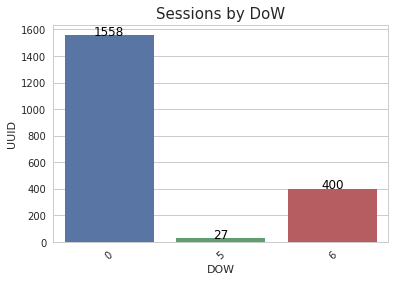

In [26]:

# traffic by DOW
ss = t.groupby('DOW')['UUID'].nunique().reset_index()
ax = sns.barplot(x="DOW", y="UUID", data=ss)
ax.set_xticklabels(ss["DOW"], rotation=40)
for index, row in ss.iterrows():
    ax.text(row.name,row.UUID, row.UUID, color='black', ha="center")
plt.title("Sessions by DoW", fontsize=15)


Text(0.5,1,'Sessions by hour of day')

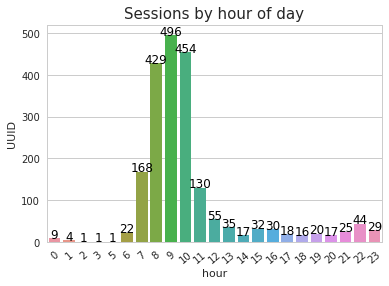

In [27]:

# traffic by hour
tt = t.groupby('hour')['UUID'].nunique().reset_index()
ax = sns.barplot(x="hour", y="UUID", data=tt)
ax.set_xticklabels(tt["hour"], rotation=40)
for index, row in tt.iterrows():
    ax.text(row.name,row.UUID, row.UUID, color='black', ha="center")
plt.title("Sessions by hour of day", fontsize=15)


/home/aksel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


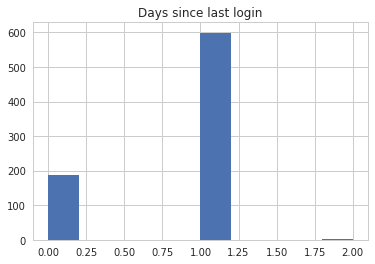

In [28]:

# define active users: A user is active if they logged in within 3 months
# find first timestamp by visitId
t['min_start_time'] = t.groupby(['user', 'UUID'])['start_time'].transform(min)

tmp = t[['user','UUID','min_start_time']].drop_duplicates().reset_index().sort_values(['user','min_start_time'])
tmp['last_visit_time'] = tmp.groupby(['user'])['min_start_time'].apply(lambda x: x.shift(1))
tmp['days_since_last_login'] = tmp['last_visit_time'] - tmp['min_start_time']

# distribution of days since last login
s = tmp[tmp['days_since_last_login'].notnull()]
plt.hist(abs(s['days_since_last_login'].dt.days))
plt.title("Days since last login")

tmp.loc[tmp['last_visit_time'].notnull(), 'days']=(tmp['last_visit_time']-tmp['min_start_time']).dt.days
# tmp.loc[tmp['last_visit_time'].notnull(), 'days']=(tmp['last_visit_time']-tmp['min_start_time'])
tmp['user_visit_cnt'] = tmp.groupby(['user']).UUID.transform('nunique')
tmp['90_percentile_days_tll'] = tmp.groupby(['user']).days.transform(lambda x: np.percentile(x,90))
tmp.loc[tmp.user_visit_cnt<10, '90_percentile_days_tll'] = np.nan
# tmp['90_percentile_days_to_return'] = tmp.transform(helper, axis=1)
# tmp.loc[(tmp['user_visit_cnt']>10),'90_percentile_days_to_return'] = tmp['90_percentile_days_tll']

tmp['avg_days_tll'] = tmp.groupby(['user']).days.transform(lambda x: x.mean(skipna=True))

t = t.merge(tmp[['user','UUID','last_visit_time','days_since_last_login','90_percentile_days_tll','avg_days_tll']], on=['UUID','user'], how='left')
t['active']=t.start_time>=dt.now()- relativedelta(months=3)